In [ ]:
"""
features, shape, iter, cv, public
01, raw+kmeans+encode, 207, 610, 0.37186, 0.371688
02, raw+kmeans,
03, raw, 111, 805, 0.38474, 0.382972
04, cat+reduce, 236, 1205, 0.370010,
05, raw numeric no norm, 111, 676, 0.385506, 0.382042
06, cat+discrete, 390, 1294, 0.361520
07, raw+reduce, 252, 909, 0.383301
08, raw+ranking, 1387, 0.384005, 0.382578
"""

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import xgboost as xgb
%matplotlib inline

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

selected = np.random.rand(train.shape[0]) < 0.8

In [3]:
# ETL
ID = test.Id.values

categorical = ['T1_V' + str(i) for i in list(range(4, 10)) + [11, 12, 15, 16, 17]] + \
                ['T2_V' + str(i) for i in [3, 5, 11, 12, 13]]

numeric = set(train.columns).difference(categorical + ['Hazard', 'Id'])
numeric = list(numeric)

In [27]:
%%time
import itertools
# building pandas to vw script
struct = {'A': ['T1_V1', 'T1_V2'],
          'B': ['T1_V3', 'T1_V4']}


tmp = train.copy()
for key in struct.keys():
    tmp['|'+key] = ''
    
struct = [x2 for x1 in [['|'+k]+v for k, v in struct.items()] for x2 in x1]
tmp[struct].apply(lambda x: ' '.join([k+'_'+str(v) for k, v in x.iteritems()]), axis=1)


# tmp = train.apply(lambda x: ' '.join([k+'_'+str(v) for k, v in x.iteritems()]), axis=1)
# names = train.columns
# for name in names:
#     tmp = name+'_'+train[name].map(str)

# print(tmp)

CPU times: user 848 ms, sys: 0 ns, total: 848 ms
Wall time: 851 ms


In [63]:
%%time
toConvert = {'cat': {'A': categorical},
             'num': {'B': numeric}}

tmp = train.copy()
ordering = ['Hazard']
for vtype, namespaces in toConvert.items():
    for namespace, labels in namespaces.items():
        ordering.append(namespace)
        tmp[namespace] = '|' + namespace        
        
        for lable in labels:
            ordering.append(lable)
            if vtype == 'cat':
                tmp[lable] = lable+'_'+tmp[lable].map(str)
            elif vtype == 'num':
                tmp[lable] = lable+':'+tmp[lable].map(str)
            else:
                raise
                
tmp[ordering].to_csv('../output/test.vw', index=False, header=False, sep=' ')

CPU times: user 2.3 s, sys: 32 ms, total: 2.33 s
Wall time: 2.33 s


In [5]:
# count features

count_features = {}
for cat in categorical:
    count_features[cat] = train[cat].value_counts().reset_index().rename(columns={'index': cat, 0: cat+'_cnt'})

tmp_train = train.copy()
tmp_test = test.copy()
for k, v in count_features.iteritems():
    tmp_train = pd.merge(tmp_train, v, on=k)
    tmp_test = pd.merge(tmp_test, v, on=k)
    

In [4]:
%%time
# kmeans features

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()

kmeans = KMeans(80, random_state=12345, n_init=1)
feat_kmeans_train = kmeans.fit_transform(SS.fit_transform(train[numeric]))
feat_kmeans_test = kmeans.transform(SS.transform(test[numeric]))

print 'variance lost:'
print kmeans.inertia_ / KMeans(1, random_state=12345, n_init=1).fit(train[numeric]).inertia_

feat_kmeans_train = pd.DataFrame(feat_kmeans_train).add_prefix('kmeans_')
feat_kmeans_test = pd.DataFrame(feat_kmeans_test).add_prefix('kmeans_')

variance lost:
0.498810867841
Wall time: 21.1 s


In [53]:
# categorical encoding
from sklearn.preprocessing import StandardScaler

feat_encode_train = train[categorical].copy()
feat_encode_test = test[categorical].copy()

for cat in categorical:
    hot_deck = train.groupby(cat).Hazard.mean().reset_index().rename(columns={'Hazard': 'encode_'+cat})
    feat_encode_train = pd.merge(feat_encode_train, hot_deck, on=cat)
    del feat_encode_train[cat]
    
    feat_encode_test = pd.merge(feat_encode_test, hot_deck, on=cat)
    del feat_encode_test[cat]
    
names = feat_encode_train.columns
ss = StandardScaler()
feat_encode_train[names] = ss.fit_transform(feat_encode_train.values)
feat_encode_test[names] = ss.transform(feat_encode_test.values)

encode_T1_V4     1.011131
encode_T1_V5     1.003089
encode_T1_V6     0.999460
encode_T1_V7     1.025445
encode_T1_V8     0.985815
encode_T1_V9     1.000703
encode_T1_V11    1.001235
encode_T1_V12    0.987670
encode_T1_V15    1.007230
encode_T1_V16    1.005126
encode_T1_V17    1.003132
encode_T2_V3     0.998128
encode_T2_V5     1.001219
encode_T2_V11    1.002282
encode_T2_V12    1.004119
encode_T2_V13    0.994556
dtype: float64

In [81]:
%%time
# reduce
from xgboost import XGBRegressor
import xgboost as xgb

feat_reduce_train = pd.DataFrame()
feat_reduce_test = pd.DataFrame()

for num in numeric:
    dTmp = xgb.DMatrix(train[[num]], label=train.Hazard)
    reg = xgb.train({'max_depth':8, 'min_child_weight':30, 'objective':'reg:linear'}, dTmp, 1)
    
    feat_reduce_train['discrete_'+num] = reg.predict(dTmp, pred_leaf=True)
    feat_reduce_train['discrete_'+num] = feat_reduce_train['discrete_'+num].map(str)
    
    feat_reduce_test['discrete_'+num] = reg.predict(xgb.DMatrix(test[[num]]), pred_leaf=True)
    feat_reduce_test['discrete_'+num] = feat_reduce_test['discrete_'+num].map(str)

Wall time: 6.86 s


In [73]:
# discrete

feat_discrete_train = train[numeric].applymap(str)
feat_discrete_test = test[numeric].applymap(str)

In [ ]:
# knn

In [88]:
# combine all features
cTrain = train[numeric+categorical]
cTest = test[numeric+categorical]

# cTrain = pd.concat([train[numeric+categorical], feat_reduce_train], axis=1)
# cTest = pd.concat([test[numeric+categorical], feat_reduce_test], axis=1)

In [89]:
%%time
from sklearn.feature_extraction import DictVectorizer

DV = DictVectorizer(sparse=False)

train_np = DV.fit_transform(cTrain.T.to_dict().values())
test_np = DV.transform(cTest.T.to_dict().values())

print train_np.shape

dTrain = xgb.DMatrix(train_np, label=train.Hazard)
dTest = xgb.DMatrix(test_np)

(50999L, 111L)
Wall time: 7.69 s


In [86]:
%%time
import gini
import re

param = {'max_depth':7, 'eta':0.01, 'objective':'reg:linear',
         'gamma':0, 'min_child_weight': 30, 'subsample': 1,
         'colsample_bytree': 0.5, 'nthread':4, 'silent':0
        }

result = xgb.cv(param, dTrain, 2000, nfold=5, feval=gini.xgb_gini)

cv = [[float(x[0]), float(x[1])]
         for y in result
             for x in re.findall('cv-test-gini:([0-9.]+)\+[0-9.]+\tcv-train-gini:([0-9.]+)', y)]

[0]	cv-test-gini:0.329071+0.034467	cv-train-gini:0.360087+0.018541
[1]	cv-test-gini:0.316241+0.013305	cv-train-gini:0.349532+0.006672
[2]	cv-test-gini:0.321524+0.013309	cv-train-gini:0.354808+0.006272
[3]	cv-test-gini:0.321718+0.017581	cv-train-gini:0.358853+0.004617
[4]	cv-test-gini:0.320582+0.019589	cv-train-gini:0.362401+0.002471
[5]	cv-test-gini:0.325815+0.015675	cv-train-gini:0.367266+0.004152
[6]	cv-test-gini:0.328896+0.015151	cv-train-gini:0.369838+0.005174
[7]	cv-test-gini:0.330595+0.013829	cv-train-gini:0.374135+0.003595
[8]	cv-test-gini:0.332481+0.014355	cv-train-gini:0.374669+0.004186
[9]	cv-test-gini:0.332309+0.014722	cv-train-gini:0.376554+0.002717
[10]	cv-test-gini:0.332017+0.013845	cv-train-gini:0.375504+0.002372
[11]	cv-test-gini:0.333039+0.014476	cv-train-gini:0.376700+0.003062
[12]	cv-test-gini:0.334414+0.014805	cv-train-gini:0.377370+0.003766
[13]	cv-test-gini:0.335150+0.015076	cv-train-gini:0.377892+0.005239
[14]	cv-test-gini:0.335550+0.015515	cv-train-gini:0.378379

Wall time: 6min 16s


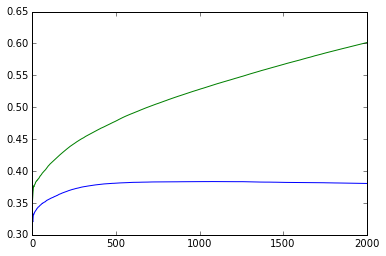

In [87]:
from matplotlib import pyplot as plt

cv = np.array(cv)
plt.plot(cv[:, 0])
plt.plot(cv[:, 1])

In [105]:
%%time
### ranking fit #######################################
import gini
import re

dTrain = xgb.DMatrix(train_np, label=train.Hazard)

param = {'max_depth':7, 'eta':0.01, 'objective':'multi:softmax',
         'gamma':0, 'min_child_weight': 30, 'subsample': 1,
         'colsample_bytree': 0.5, 'nthread':4, 'silent':0, 'num_class':70
        }

result = xgb.cv(param, dTrain, 2000, nfold=5, feval=gini.xgb_gini)

cv = [[float(x[0]), float(x[1])]
         for y in result
             for x in re.findall('cv-test-gini:([0-9.]+)\+[0-9.]+\tcv-train-gini:([0-9.]+)', y)]

[0]	cv-test-gini:1.000000+0.000000	cv-train-gini:1.000000+0.000000
[1]	cv-test-gini:1.000000+0.000000	cv-train-gini:1.000000+0.000000
[2]	cv-test-gini:1.000000+0.000000	cv-train-gini:1.000000+0.000000
[3]	cv-test-gini:1.000000+0.000000	cv-train-gini:1.000000+0.000000
[4]	cv-test-gini:1.000000+0.000000	cv-train-gini:1.000000+0.000000
[5]	cv-test-gini:1.000000+0.000000	cv-train-gini:1.000000+0.000000
[6]	cv-test-gini:1.000000+0.000000	cv-train-gini:1.000000+0.000000
[7]	cv-test-gini:1.000000+0.000000	cv-train-gini:1.000000+0.000000
[8]	cv-test-gini:1.000000+0.000000	cv-train-gini:1.000000+0.000000


KeyboardInterrupt: 

In [106]:
%%time
import gini

param = {'max_depth':7, 'eta':0.01, 'objective':'reg:linear',
         'gamma':0, 'min_child_weight': 30, 'subsample': 1,
         'colsample_bytree': 0.5, 'nthread':4, 'silent':0
        }

model = xgb.train(param, dTrain, 676, feval=gini.xgb_gini)

XGBoostError: must set num_class to use softmax

In [31]:
importance = (pd.DataFrame
                  .from_dict(model.get_fscore(), orient='index')
                  .reset_index()
                  .rename(columns={'index':'feat', 0:'importance'}))

vocab = (pd.DataFrame
             .from_dict(DV.vocabulary_, orient='index')
             .reset_index()
             .rename(columns={'index':'variable', 0:'feat'}))

vocab.feat = vocab.feat.map(lambda x: 'f'+str(x))

importance = pd.merge(importance, vocab, on='feat')
importance.sort(columns='importance', ascending=False).to_csv('importance_xgb.csv', index=False)

In [92]:
yhat = model.predict(dTest)
pd.DataFrame({'Id': ID, 'Hazard': yhat}).reindex_axis(['Id', 'Hazard'], 1).to_csv('../output/pred08.csv', index=0)

In [115]:
"""
original: 3.836318 / 0.378389
kmeans with 80 clusters: 3.844969
"""
5.391478

(40869, 191)